In [6]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, lr_scheduler
import shutil, sys   
import copy
import torch.nn as nn

import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy 

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [7]:
BATCH_SIZE = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

In [8]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        img, label = original_tuple
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (img, label, path)
        return tuple_with_path

In [9]:
# Change to fit hardware

data_dir = '/scratch/kv942/ccm_proj/datadir_rnd/'

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
class_names = image_datasets['test'].classes

test_dataset = ImageFolderWithPaths(os.path.join(data_dir, 'test'), data_transforms['test'])
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                       )


In [10]:
# view test image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [11]:
PATH = '/scratch/sg5783/CCM_Project/final_folder/model_weights/random_data_split/VGG16_40.pth'
model = torchvision.models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 8)

model.load_state_dict(torch.load(PATH, map_location='cpu'))
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
class VGG(nn.Module):
    def __init__(self, trained_model):
        super(VGG, self).__init__()
        
        # get the trained VGG16 network
        self.vgg = trained_model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:30]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of vgg16
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)


In [13]:
# initialize the VGG model
vgg = VGG(model)

# set the evaluation mode
vgg.eval()

VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxPoo

In [16]:
def draw_gradCAM(vgg, image, image_path):
    
    # get the most likely prediction of the model
    out = vgg(image)
    
    pred = out.argmax(dim=1)
    print ("predicted class : ", class_names[pred])
    
    # get the gradient of the output with respect to the parameters of the model
    out[:, 2].backward()

    # pull the gradients out of the model
    gradients = vgg.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = vgg.get_activations(image).detach()

    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    print("heatmap")
    # draw the heatmap
    plt.matshow(heatmap.squeeze())
    plt.show()
    
    ## Now, we can use OpenCV to interpolate the heat-map and project it onto the original image
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    path = 'map' + image_path.split('/')[-1]
    cv2.imwrite(path, superimposed_img)
    
    image = mpimg.imread(path)
    plt.imshow(image)

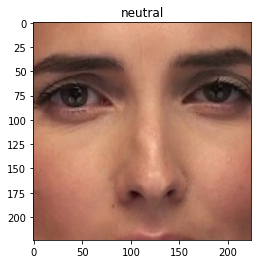

actual class :  neutral
predicted class :  neutral
heatmap


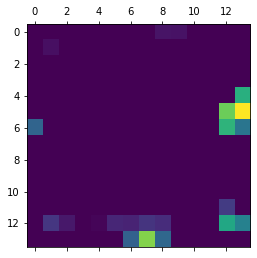

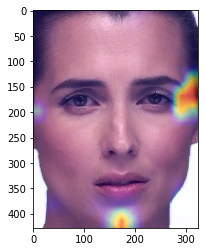

In [17]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

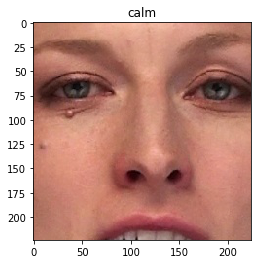

actual class :  calm
predicted class :  calm
heatmap


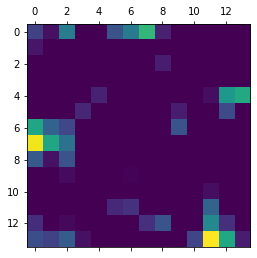

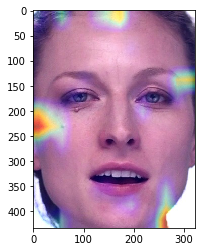

In [18]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

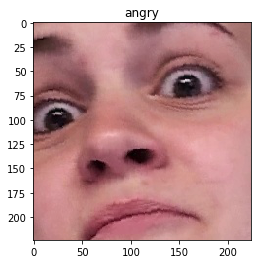

actual class :  angry
predicted class :  fearful
heatmap


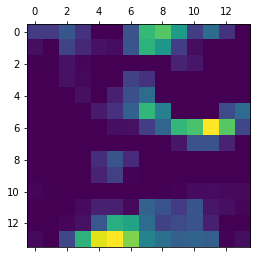

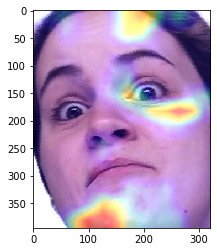

In [19]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

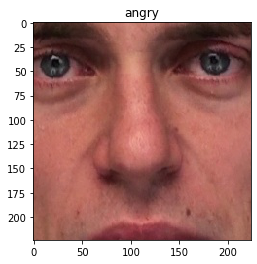

actual class :  angry
predicted class :  angry
heatmap


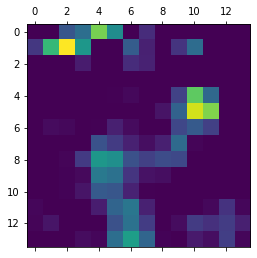

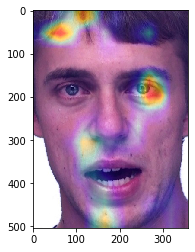

In [20]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

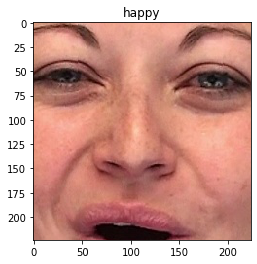

actual class :  happy
predicted class :  happy
heatmap


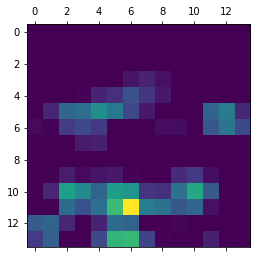

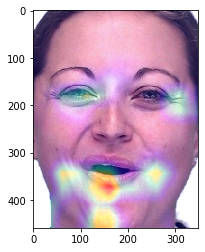

In [21]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

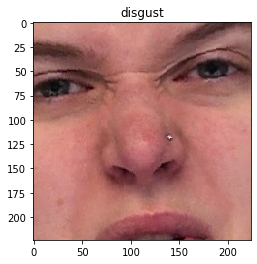

actual class :  disgust
predicted class :  disgust
heatmap


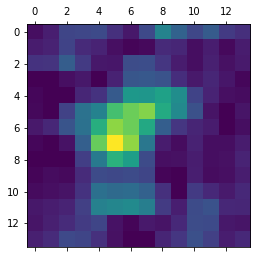

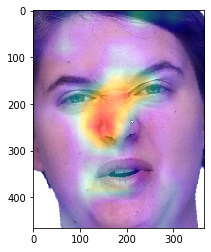

In [22]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

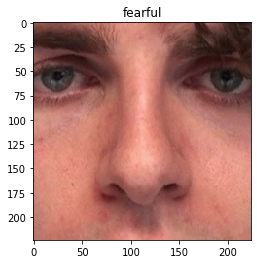

actual class :  fearful
predicted class :  fearful
heatmap


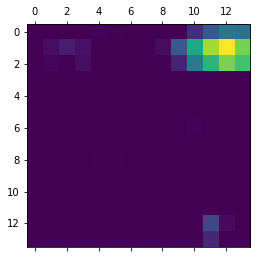

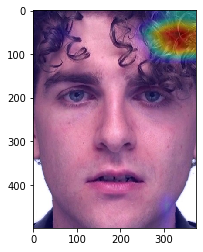

In [23]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

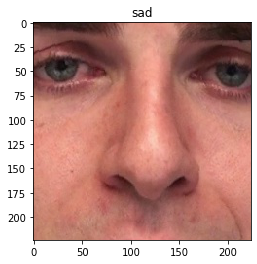

actual class :  sad
predicted class :  sad
heatmap


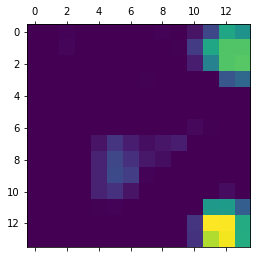

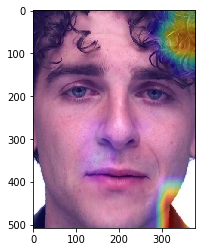

In [24]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

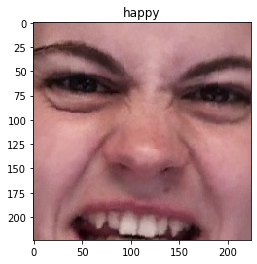

actual class :  happy
predicted class :  angry
heatmap


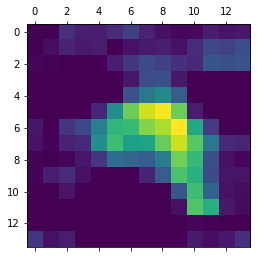

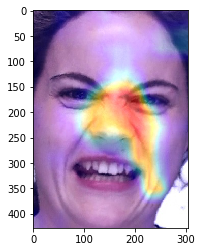

In [25]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

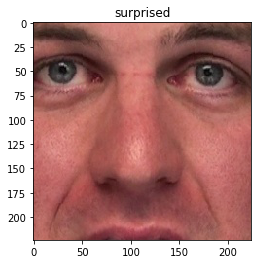

actual class :  surprised
predicted class :  surprised
heatmap


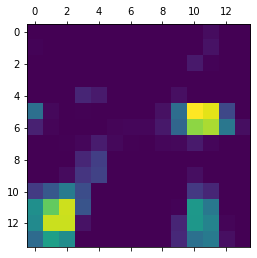

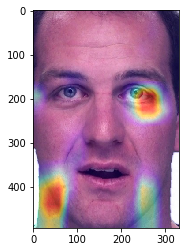

In [26]:
image, label, image_path = next(iter(test_loader))

image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)

In [24]:
class_names

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

label tensor([6])


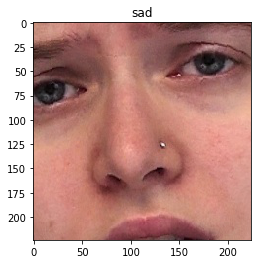

actual class :  sad
predicted class :  sad
heatmap


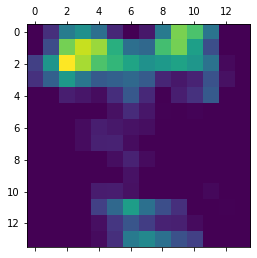

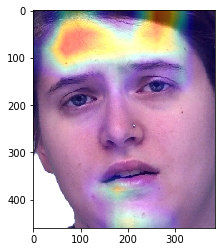

In [27]:
image, label, image_path = next(iter(test_loader))
print("label", label)
image_path = image_path[0]
#print(image, classes, paths)
out = torchvision.utils.make_grid(image)
title= class_names[label]
imshow(out, title)
print("actual class : ", title)
draw_gradCAM(vgg, image, image_path)